## Imports and Setup

In [1]:
import os
import pandas as pd
import geopandas as gpd
import logging
import joblib
import torch

import sys
sys.path.insert(0, "../utils/")
import data_utils
import config_utils
import pred_utils
import model_utils
import cnn_utils

%load_ext autoreload
%autoreload 2

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Data Configurations

In [28]:
iso_code = "SEN"
shapename = "Foundiougne"
cwd = os.path.dirname(os.getcwd())

# Model configuration file
model_config_file = os.path.join(cwd, f"configs/cnn_configs/vgg16.yaml")
model_config = config_utils.load_config(model_config_file)
model_config["iso_codes"] = [iso_code]
classes = {1: model_config["pos_class"], 0: model_config["neg_class"]}

# Model file
exp_dir = os.path.join(cwd, model_config["exp_dir"], f"{iso_code}_{model_config['config_name']}")
model_file = os.path.join(exp_dir, f"{iso_code}_{model_config['config_name']}.pth")
model = pred_utils.load_cnn(model_config, classes, model_file)

## Load Training/Test Data

In [103]:
data = model_utils.load_data(model_config, attributes=["rurban", "iso"], verbose=False)
filepaths = data_utils.get_image_filepaths(model_config, data)
data[data['class'] == 'school'].sample(3)

,UID,source,iso,country,region,subregion,name,giga_id_school,clean,validated,class,ghsl_smod,rurban,dataset,geometry
6336,UNICEF-SEN-SCHOOL-00009104,UNICEF,SEN,Senegal,Africa,Sub-Saharan Africa,EE GOUYE MOURIDE,085dd943-fd90-304b-b41c-9b5b01c1a9a6,0,0.0,school,30,urban,train,POINT (-1665266.009 1774425.483)
1944,UNICEF-SEN-SCHOOL-00002815,UNICEF,SEN,Senegal,Africa,Sub-Saharan Africa,EE LIMANE,9f5f3a0d-114e-309d-92ad-829a2e36d38c,0,0.0,school,21,urban,test,POINT (-1612650.287 1709330.852)
2348,UNICEF-SEN-SCHOOL-00003357,UNICEF,SEN,Senegal,Africa,Sub-Saharan Africa,EE DIAMAFARA,92d4b5d1-f0f6-3455-b8d6-4180a8b1e0a3,0,0.0,school,13,rural,train,POINT (-1536531.125 1716078.212)


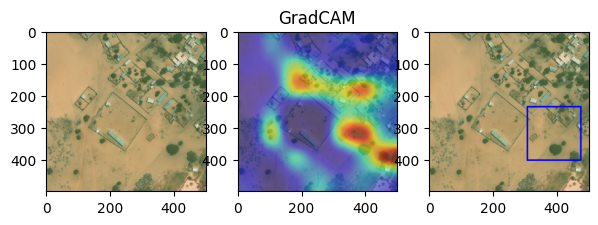

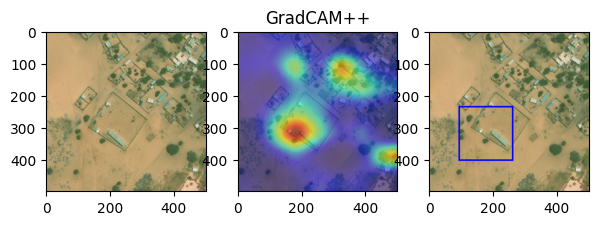

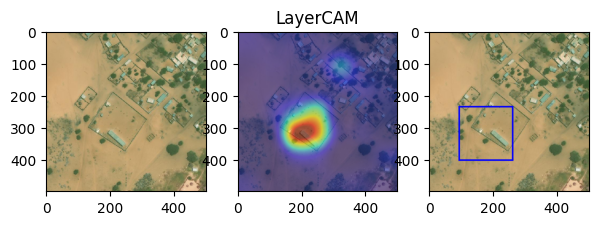

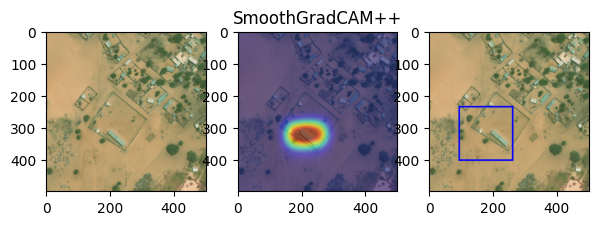

In [106]:
index = 2116
pred_utils.compare_cams(filepaths[index], model, model_config, classes, model_file)

## Load Model Outputs

In [29]:
name = f"{iso_code}_{shapename}"
out_dir = os.path.join(cwd, "output", iso_code, "results")
out_file = os.path.join(out_dir, f"{name}_{model_config['config_name']}_results.gpkg")

data = gpd.read_file(out_file)
sat_dir = os.path.join(cwd, "output", iso_code, "images", shapename)
filepaths = data_utils.get_image_filepaths(model_config, data, in_dir=sat_dir)
data[data['pred'] == 'school'].sample(3)

,UID,shapeName,pred,prob,geometry
2172,2172,Foundiougne,school,0.979372,"POLYGON ((-1823266.608 1570949.613, -1823266.6..."
614,614,Foundiougne,school,0.721548,"POLYGON ((-1833766.608 1588799.613, -1833766.6..."
2742,2742,Foundiougne,school,0.612566,"POLYGON ((-1818316.608 1566599.613, -1818316.6..."


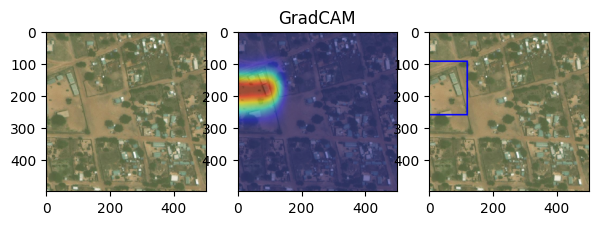

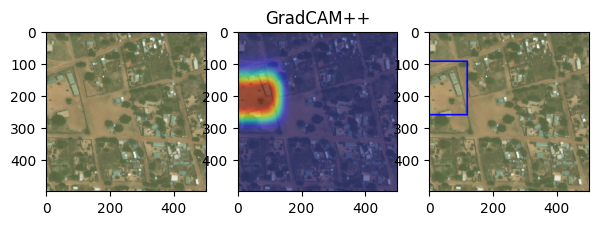

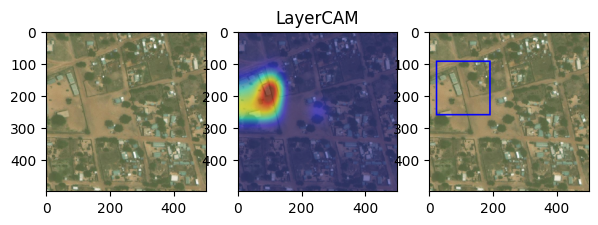

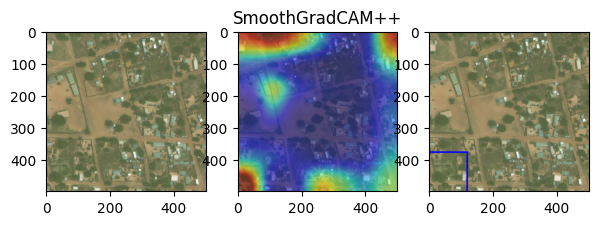

In [24]:
index = 5605
pred_utils.compare_cams(filepaths[index], model, model_config, classes, model_file)

## Visualize CAMs for Different Images

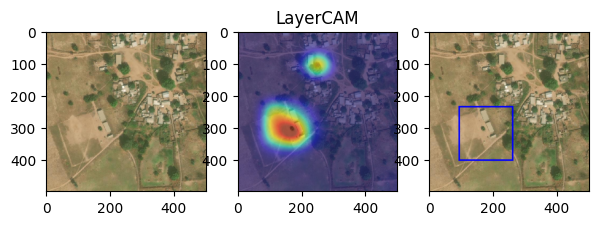

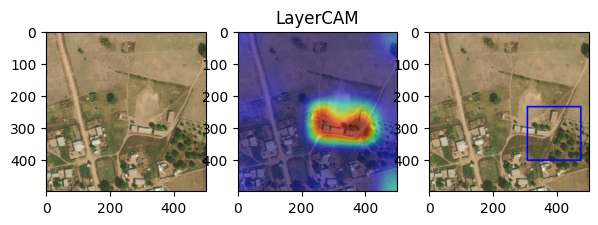

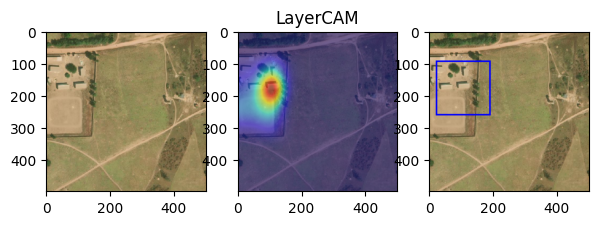

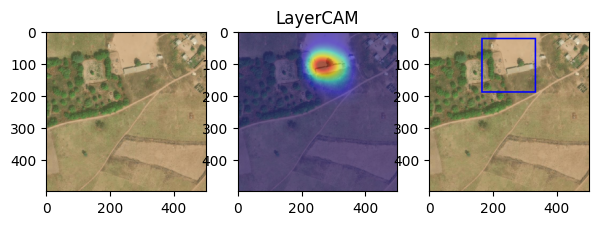

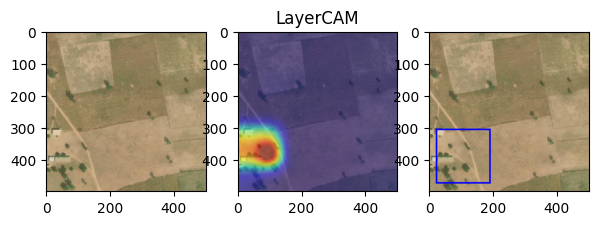

In [30]:
from torchcam.methods import LayerCAM
model = pred_utils.load_cnn(model_config, classes, model_file, verbose=False).eval()
cam_extractor = LayerCAM(model)

for index in list(data[data['pred'] == 'school'].sample(5).index):
    _, bbox = pred_utils.generate_cam(model_config, filepaths[index], model, cam_extractor, title="LayerCAM")

## Georeference Images

In [31]:
sat_config_file = os.path.join(cwd, 'configs/sat_configs/sat_config_500x500_60cm.yaml')
sat_config = config_utils.load_config(sat_config_file)
geotiff_dir = data_utils._makedir(os.path.join("output", iso_code, "geotiff", shapename))
pred_utils.georeference_images(data[data["pred"] == "school"], sat_config, sat_dir, geotiff_dir)

100%|███████████████████████████████████████████████████████████████████████████████| 283/283 [00:00<00:00, 7959.69it/s]


## Generate Bounding Boxes from CAMs

In [32]:
results = pred_utils.generate_cam_bboxes(
    data[data['pred'] == 'school'].reset_index(drop=True), 
    model_config,
    geotiff_dir, 
    model, 
    cam_extractor
)
out_dir = os.path.join(cwd, "output", iso_code, "results")
filename = f"{iso_code}_{shapename}_{model_config['model']}_cam.gpkg"
out_file = os.path.join(out_dir, filename)
results.to_file(out_file, driver="GPKG")

100%|█████████████████████████████████████████████████████████████████████████████████| 283/283 [00:44<00:00,  6.40it/s]
